In [34]:
import json
from pathlib import Path
from pprint import pprint
import pandas as pd
from datetime import timedelta

In [35]:
timeframes = ['1h', '4h', '12h', '1d']

data_sets = dict()
for tf in timeframes:
    dfs = []
    for i, sel in enumerate(['1d_volumes_30', '1w_volumes_100']):
        log_path = Path(f"/home/ross/coding/pi_2/modular_trader/records/trail_fractals_{tf}_None_5_2_{sel}/perf_log.json")
        with open(log_path, 'r') as file:
            perf_log = json.load(file)
        perf_stats = [{'time': d['timestamp'],
                       # 'bal': d['balance'],
                       'real_l': d['real_rpnl_long'],
                       'sim_l': d['sim_rpnl_long'],
                       'wanted_l': d['wanted_rpnl_long'],
                       'unwanted_l': d['unwanted_rpnl_long'],
                       'real_s': d['real_rpnl_short'],
                       'sim_s': d['sim_rpnl_short'],
                       'wanted_s': d['wanted_rpnl_short'],
                       'unwanted_s': d['unwanted_rpnl_short'],
                       } for d in perf_log]
        perf_df = pd.DataFrame(perf_stats)
        perf_df[f'r_{i}'] = (perf_df.real_l + perf_df.real_s)
        perf_df[f'u_{i}'] = (perf_df.unwanted_l + perf_df.unwanted_s)
        perf_df[f'sw_{i}'] = (perf_df.sim_l + perf_df.sim_s) - perf_df[f'u_{i}']
        perf_df = perf_df.drop(['real_l', 'real_s', 'sim_l', 'sim_s', 'wanted_l', 'wanted_s', 'unwanted_l', 'unwanted_s'], axis=1)
        perf_df['time'] = pd.to_datetime(perf_df.time, format='%d/%m/%y %H:%M')
        perf_df = perf_df.set_index('time', drop=True)
        dfs.append(perf_df)
    
    df = pd.concat(dfs, axis=1)
    df = df.sort_index()
    df = df.fillna(0)    
    week_ago = (df.index[-1] - timedelta(weeks=1))
    df = df.loc[df.index > week_ago]
    
    df['real'] = (df.r_0+df.r_1).cumsum()
    df['sim_wanted'] = (df.sw_0+df.sw_1).cumsum()
    df['unwanted'] = (df.u_0+df.u_1).cumsum()
    df = df[['real', 'sim_wanted', 'unwanted']]
    data_sets[tf] = df

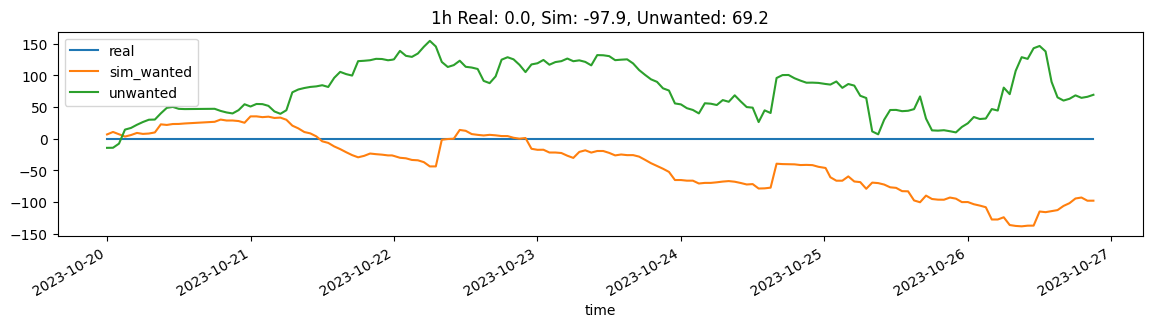

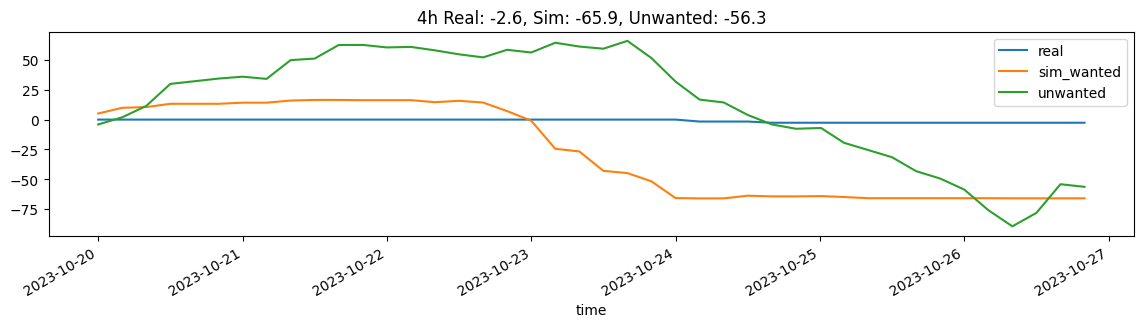

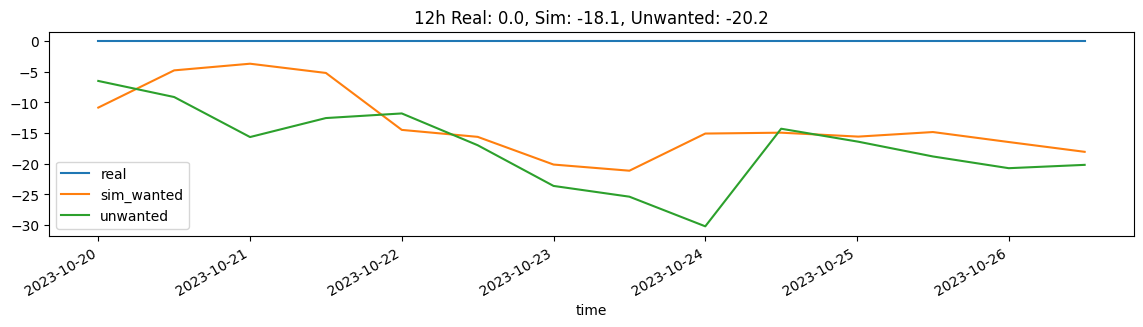

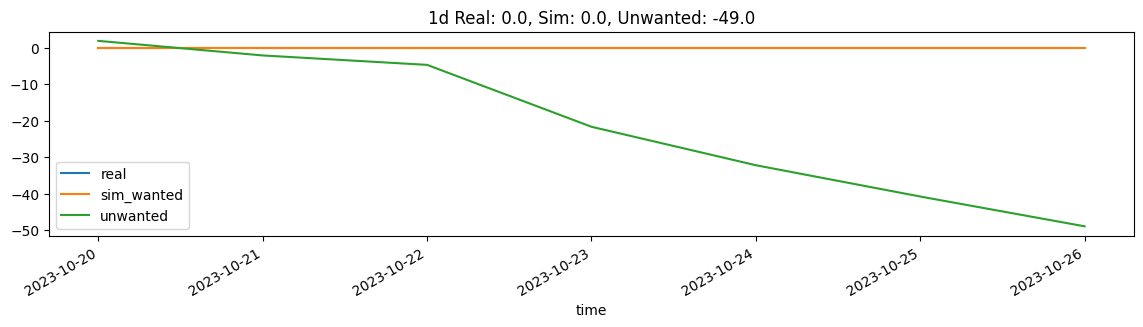

In [36]:
for tf in timeframes:
    t = f"{tf} Real: {data_sets[tf].real.iloc[-1]:.1f}, Sim: {data_sets[tf].sim_wanted.iloc[-1]:.1f}, Unwanted: {data_sets[tf].unwanted.iloc[-1]:.1f}"
    data_sets[tf].plot(title=t, figsize=(14, 3))